**🔧 Setup Required**: Before running this notebook, please follow the [setup instructions](../../README.md#setup-instructions) to configure your environment and API keys.

# Building a Routing Pipeline with ConditionalRouter

Welcome to this notebook where we'll explore the `ConditionalRouter` in Haystack. The ConditionalRouter is the most flexible routing component, allowing you to direct queries to different processing paths based on custom conditions.

## What You'll Learn

- How to implement conditional routing based on query analysis
- Using Jinja2 expressions for complex routing logic
- Different routing strategies: keyword-based and query classification
- Building a multi-path pipeline that adapts to different query types
- Best practices for defining default routes

## Why ConditionalRouter Matters

Not all queries are created equal. The ConditionalRouter allows you to:
- Route factual queries to keyword-based retrieval
- Send semantic queries to embedding-based search
- Direct complex queries to hybrid approaches
- Optimize both cost and quality by choosing the best approach for each query

## 1. Core ConditionalRouter Components

Let's start by importing the ConditionalRouter and understanding its key features:

- **Jinja2 Expressions**: Use template syntax for complex conditions
- **Multiple Routes**: Define as many output paths as needed
- **Flexible Logic**: Combine multiple conditions with AND/OR logic
- **Metadata Access**: Route based on any available metadata

In [1]:
# Import routing components
from haystack.components.routers import ConditionalRouter

## 2. Understanding ConditionalRouter

The `ConditionalRouter` is the most flexible routing component. It evaluates conditions against input data and routes to different outputs based on the results.

### Key Features

- **Jinja2 Expressions**: Use template syntax for complex conditions
- **Multiple Routes**: Define as many output paths as needed
- **Flexible Logic**: Combine multiple conditions with AND/OR logic
- **Metadata Access**: Route based on any available metadata

### Common Use Cases

1. **Query Type Detection**: Route factual vs. conceptual questions
2. **Keyword Matching**: Direct queries containing specific terms
3. **Length-Based Routing**: Handle short vs. long queries differently
4. **Metadata Filtering**: Route based on query metadata

### Important: Default Routes

Always include a default/fallback route with `"condition": "{{ True }}"` as the last route. This ensures that queries not matching any specific condition are still handled gracefully, preventing `NoRouteSelectedException` errors.

Let's create a simple example that routes queries based on keywords.

In [2]:
# Example 1: Simple Keyword-Based Routing
# This router will direct queries to different paths based on content

# Define routing rules using Jinja2 template syntax
routes = [
    {
        "condition": "{{ 'technical' in query.lower() or 'api' in query.lower() or 'code' in query.lower() }}",
        "output": "{{ query }}",
        "output_name": "technical",
        "output_type": str,
    },
    {
        "condition": "{{ 'concept' in query.lower() or 'explain' in query.lower() or 'what is' in query.lower() }}",
        "output": "{{ query }}",
        "output_name": "conceptual",
        "output_type": str,
    },
    {
        "condition": "{{ 'how to' in query.lower() or 'tutorial' in query.lower() }}",
        "output": "{{ query }}",
        "output_name": "tutorial",
        "output_type": str,
    },
    {
        # Default route: catch all queries that don't match other conditions
        "condition": "{{ True }}",
        "output": "{{ query }}",
        "output_name": "general",
        "output_type": str,
    },
]

# Create the router
query_router = ConditionalRouter(routes=routes)

# Test the router
test_queries = [
    "How do I use the technical API?",
    "Explain what is Haystack?",
    "Show me a tutorial on building pipelines",
    "What are the best practices?"
]

print("Testing Query Router:\n")
for query in test_queries:
    result = query_router.run(query=query)
    route = list(result.keys())[0] if result else "no_match"
    print(f"Query: '{query}'")
    print(f"Routed to: {route}\n")

Testing Query Router:

Query: 'How do I use the technical API?'
Routed to: technical

Query: 'Explain what is Haystack?'
Routed to: conceptual

Query: 'Show me a tutorial on building pipelines'
Routed to: tutorial

Query: 'What are the best practices?'
Routed to: general



## 3. Building a Query Classification Router

For more sophisticated routing, we can use the query type to determine the best processing strategy. Let's create a router that distinguishes between:

1. **Factual Queries**: Direct questions seeking specific information
   - Best served by: BM25 (keyword matching)
   - Example: "What is the release date of Haystack 2.0?"

2. **Semantic Queries**: Questions about concepts or relationships
   - Best served by: Dense embeddings (semantic search)
   - Example: "How does Haystack compare to other frameworks?"

3. **Complex Queries**: Multi-faceted questions
   - Best served by: Hybrid search (both methods)
   - Example: "What are the technical capabilities and use cases?"

This approach optimizes both speed and accuracy by matching queries to the most appropriate retrieval method.

In [3]:
# Define routes based on query characteristics
classification_routes = [
    {
        # Factual queries: specific facts, names, dates, numbers
        "condition": "{{ 'when' in query.lower() or 'who' in query.lower() or 'what is the' in query.lower() }}",
        "output": "{{ query }}",
        "output_name": "factual",
        "output_type": str,
    },
    {
        # Semantic queries: understanding, comparison, explanation
        "condition": "{{ 'how does' in query.lower() or 'compare' in query.lower() or 'difference between' in query.lower() }}",
        "output": "{{ query }}",
        "output_name": "semantic",
        "output_type": str,
    },
    {
        # Complex queries: multiple aspects or comprehensive information
        # Note: We check for 'and' keyword as an indicator of complex queries
        "condition": "{{ 'and' in query.lower() }}",
        "output": "{{ query }}",
        "output_name": "complex",
        "output_type": str,
    },
    {
        # Default route: catch-all for queries that don't match specific patterns
        "condition": "{{ True }}",
        "output": "{{ query }}",
        "output_name": "general",  # Default to general for unmatched queries
        "output_type": str,
    },
]

classification_router = ConditionalRouter(routes=classification_routes)

# Test with different query types
test_classification = [
    "When was Haystack 2.0 released?",
    "How does Haystack compare to LangChain?",
    "What are the main features and benefits of using Haystack for production applications?"
]

print("Testing Query Classification Router:\n")
for query in test_classification:
    result = classification_router.run(query=query)
    route = list(result.keys())[0] if result else "no_match"
    print(f"Query: '{query}'")
    print(f"Classified as: {route}\n")

Testing Query Classification Router:

Query: 'When was Haystack 2.0 released?'
Classified as: factual

Query: 'How does Haystack compare to LangChain?'
Classified as: semantic

Query: 'What are the main features and benefits of using Haystack for production applications?'
Classified as: complex



## 4. Visualizing ConditionalRouter Routes

Let's create a visual representation of the ConditionalRouter to see how query classification works in a complete pipeline.

In [4]:
# Build a pipeline with conditional routing for visualization
from haystack import Pipeline
from haystack.components.builders import PromptBuilder

conditional_pipeline = Pipeline()
classification_router = ConditionalRouter(routes=classification_routes)

# Add the classification router
conditional_pipeline.add_component("query_classifier", classification_router)

# Add different prompt builders for each route
factual_template = "Answer this factual question directly: {{ query }}"
semantic_template = "Provide a comprehensive explanation for: {{ query }}"
complex_template = "Give a detailed analysis addressing all aspects of: {{ query }}"

factual_prompt = PromptBuilder(template=factual_template, required_variables=["query"])
semantic_prompt = PromptBuilder(template=semantic_template, required_variables=["query"])
complex_prompt = PromptBuilder(template=complex_template, required_variables=["query"])

conditional_pipeline.add_component("factual_prompt", factual_prompt)
conditional_pipeline.add_component("semantic_prompt", semantic_prompt)
conditional_pipeline.add_component("complex_prompt", complex_prompt)

# Connect the router to the appropriate handlers
conditional_pipeline.connect("query_classifier.factual", "factual_prompt.query")
conditional_pipeline.connect("query_classifier.semantic", "semantic_prompt.query")
conditional_pipeline.connect("query_classifier.complex", "complex_prompt.query")

🚅 Components
  - query_classifier: ConditionalRouter
  - factual_prompt: PromptBuilder
  - semantic_prompt: PromptBuilder
  - complex_prompt: PromptBuilder
🛤️ Connections
  - query_classifier.factual -> factual_prompt.query (str)
  - query_classifier.semantic -> semantic_prompt.query (str)
  - query_classifier.complex -> complex_prompt.query (str)

Conditional Routing Pipeline Structure:

Pipeline diagram saved to: ../images/conditional_routing_pipeline.png


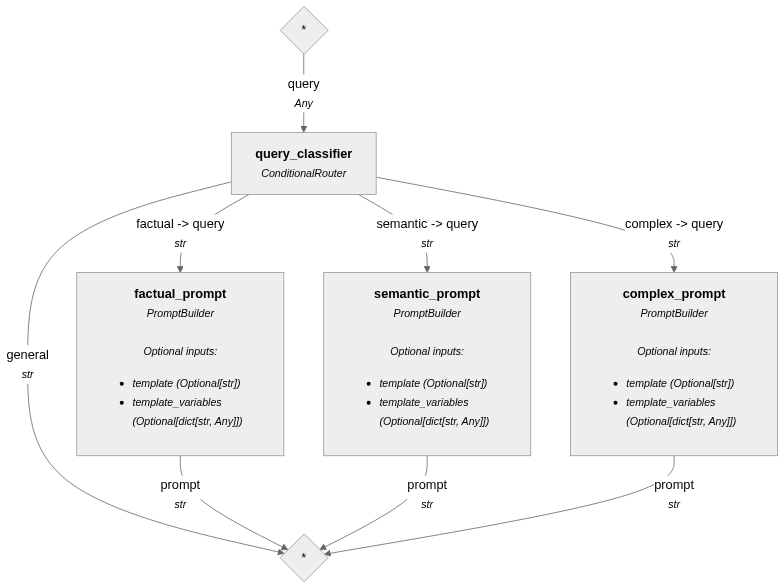



Testing the conditional routing pipeline:


Query: When was Haystack 2.0 released?
  → Routed through: factual_prompt
  → Prompt generated: Answer this factual question directly: When was Haystack 2.0 released?...

Query: How does Haystack compare to other frameworks?
  → Routed through: semantic_prompt
  → Prompt generated: Provide a comprehensive explanation for: How does Haystack compare to other fram...

Query: What are the main features and benefits?
  → Routed through: complex_prompt
  → Prompt generated: Give a detailed analysis addressing all aspects of: What are the main features a...


In [5]:
# Visualize the pipeline
import os

print("Conditional Routing Pipeline Structure:\n")
image_path = os.path.join("../images", "conditional_routing_pipeline.png")
conditional_pipeline.draw(path=image_path)
print(f"Pipeline diagram saved to: {image_path}")

# Display the pipeline
try:
    from IPython.display import Image, display
    display(Image(image_path))
except Exception as e:
    print(f"Could not display image: {e}")

# Test the pipeline
print("\n\nTesting the conditional routing pipeline:\n")
test_queries = [
    "When was Haystack 2.0 released?",
    "How does Haystack compare to other frameworks?",
    "What are the main features and benefits?"
]

for query in test_queries:
    print(f"\nQuery: {query}")
    result = conditional_pipeline.run({"query_classifier": {"query": query}})
    
    # Show which path was taken
    for key in result.keys():
        if 'prompt' in key:
            print(f"  → Routed through: {key}")
            print(f"  → Prompt generated: {result[key]['prompt'][:80]}...")

## 5. Summary and Best Practices

### What We Covered

- ✅ Basic keyword-based routing with ConditionalRouter
- ✅ Query classification for different retrieval strategies
- ✅ Building complete pipelines with routing logic
- ✅ Visualizing routing flows

### Key Takeaways

1. **Always Include Default Routes**: Use `{{ True }}` as the last condition to catch unmatched queries
2. **Use Jinja2 Expressions**: Leverage template syntax for flexible conditions
3. **Order Matters**: Routes are evaluated in order, first match wins
4. **Test Thoroughly**: Verify routing logic with diverse test queries
5. **Optimize for Your Use Case**: Match routing strategies to your specific needs

### Next Steps

- Experiment with more complex Jinja2 conditions
- Combine ConditionalRouter with other routers
- Implement cost-based routing (cheap vs. expensive models)
- Add monitoring and metrics per route

Happy routing! 🚀